In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt 

In [4]:
if not 'RESULTS_ROOT' in locals():
  RESULTS_ROOT = 'results/'

if not 'EXPERIMENT' in locals():
  EXPERIMENT = 'gdc_can1_grapevine'
  # EXPERIMENT = 'gdc_can2_grapevine'
  # EXPERIMENT = 'gdc_can3_grapevine'

  # EXPERIMENT = 'gdc_can1_grapevine_no_deficit'
  # EXPERIMENT = 'gdc_can2_grapevine_no_deficit'
  # EXPERIMENT = 'gdc_can3_grapevine_no_deficit'

  # EXPERIMENT = 'gdc_can1_grapevine_10_days_no_deficit'
  # EXPERIMENT = 'gdc_can2_grapevine_10_days_no_deficit'
  # EXPERIMENT = 'gdc_can3_grapevine_10_days_no_deficit'

experiment_path = os.path.join(RESULTS_ROOT, EXPERIMENT)
data_file = os.path.join(experiment_path, 'leaf_data.pickle')
env_input_file = os.path.join(experiment_path, 'env_input.csv')
plant_output_file = os.path.join(experiment_path, 'plant_outputs.csv')

figure_path = os.path.join(RESULTS_ROOT, 'figures/', EXPERIMENT)

In [5]:
INPUT_VARIABLES = ['Tac', 'hs', 'u', 'Rg']

INPUT_DESCS = {
    'Tac': 'Air temperature (Celsius)',
    'hs': 'Relative humidity (%)',
    'u': 'Wind speed (m/s)',
    'Rg': 'solar radiation (shortwave irradiance)',
}

OUTPUT_VARIABLES = ['An', 'E', 'Rg', 'Tleaf']

OUTPUT_DESCS = {
    'time': 'simulation time',
    'An': 'Net carbon assimilation flux of whole plant ($\\mu mol s^{-1}$)',
    'E': 'Transpiration flux of whole plant ($g h^{-1}$)',
    'Rg': 'Absorbed shortwave irradiance by whole plant ($W m_{ground}^{-2}$)',
    'Tleaf': 'Median leaf temperature (degrees Celsius)'
}

In [6]:
# Load environmental inputs
env_input = pd.read_csv(os.path.join(experiment_path, 'env_input.csv'))
env_input['time'] = pd.to_datetime(env_input['time'], format='%Y-%m-%d %H:%M:%S')

# Loading plant-level outputs
plant_output = pd.read_csv(os.path.join(experiment_path, 'plant_outputs.csv'))
plant_output['time'] = pd.to_datetime(plant_output['time'], format='%Y-%m-%d %H:%M:%S')

# Filter the environmental inputs to the time range in the experiment
start = plant_output['time'].iloc[0]
end = plant_output['time'].iloc[-1]
env_input = env_input[(start <= env_input['time']) & (env_input['time'] <= end)]
assert(len(env_input) == len(plant_output))
print(f'Time steps: {len(env_input)}')
print(f'Time range: {start} to {end}')

# Loading leaf-level plant state
from pickle import load
with open(os.path.join(experiment_path, 'leaf_data.pickle'), 'rb') as f:
  state_data = load(f)

state_variables = sorted(list(state_data.keys()))
vertex_ids = list(state_data[state_variables[0]].keys())

print(f'Available state variables: {state_variables}')
print(f'State size: {len(vertex_ids)}')
assert(len(state_data[state_variables[0]][vertex_ids[0]]) == len(env_input))

Time steps: 96
Time range: 2012-08-01 00:00:00 to 2012-08-04 23:00:00
Available state variables: ['An', 'Ci', 'E', 'Eabs', 'Ei', 'Flux', 'FluxC', 'Tlc', 'gb', 'gs', 'par_photo.dHd', 'psi_head', 'u']
State size: 360


# Reservoir Computing Experiments

In [7]:
N_SAMPLINGS = 100  # number of random samplings to test of total available reservoir state

## Reservoir computing experiments

The correlations discovered above, the stomatal conductance (`gb`) has quite a strong (positive or negative) correlation with all three environmental input signals,

For these initial experiments, we will limit ourselves to predicting a single environmental input from a single leaf property. We will start with an observable reservoir state of 64 randomly selected leaves.

As in Olivier's paper, we will use the NMSE as loss function:

$$\mathrm{NMSE} = \frac{1}{N} \sum_{t=0}^{N-1} \frac{(y(t) - \hat y(t))^2}{\mathrm{var} (y)}$$

In [8]:
from sklearn.metrics import mean_squared_error

def norm_mean_squared_error(y_true, y_pred, epsilon=1e-12):
  """Computes the normalized MSE between y_true and 
  y_pred, normalized by the variance of y_true."""
  return mean_squared_error(y_true, y_pred) / (y_true.var() + epsilon)

# Perfect predictions have an NMSE of 0.0
assert(norm_mean_squared_error(np.ones((100)), np.ones((100))) == 0)

# Signal mean as prediction results in NMSE of 1.0
y_true = np.random.rand(100)
y_pred = np.ones(100) * y_true.mean()
assert(np.allclose(norm_mean_squared_error(y_true, y_pred), 1))

In [9]:
def get_state_data_subset(state_data, size: int, N: int=1):
  """Returns a reservoir state history generated from state_data dictionary as numpy array 
  by randomly sampling [param:size] state observations. 
    size: how many state observations to return in one subset
    N: how many random subset to return (useful for calculating mean and std of perf metrics)"""
  # shape = (time_steps, n_samplings, state_size, state_variables)
  states = np.zeros((len(env_input), N, size, len(STATE_VARIABLES)))  
  for r in range(N):
    state_ids = np.random.choice(vertex_ids, size)
    for i, leaf_id in enumerate(state_ids):
      for j, variable in enumerate(STATE_VARIABLES):
        states[:, r, i, j] = np.array(state_data[variable][leaf_id])
  return states

STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
states = get_state_data_subset(state_data, 1, 1)
assert(states.shape == (len(env_input), 1, 1, len(STATE_VARIABLES)))

In [10]:
from sklearn.linear_model import Ridge
from typing import Tuple

def train_readout(target: np.ndarray, states: np.ndarray, alpha=1.0) -> Ridge:
  """Takes a numpy array of target signal and reservoir states and returns a fitted model.
    target: shape (time_steps)
    states: shape (time_steps, state_size)
  """
  readout = Ridge(alpha=alpha)
  readout.fit(states, target)
  return readout

def evaluate_reservoir_training_score(target: np.ndarray, states: np.ndarray, alpha=1.0) -> Tuple[float, float]:
  """Takes a numpy array of target signal and multiple reservoir state histories
   and returns the model's mean and stdev of NMSE.
  
    target: shape (time_steps)
    states: shape (time_steps, n_samples, state_size)
  """
  n_tests = states.shape[1]
  errors = np.zeros(n_tests)
  for i in range(n_tests):
    readout = train_readout(target, states[:, i, :], alpha=alpha)
    y_pred = readout.predict(states[:, i, :])
    errors[i] = norm_mean_squared_error(target, y_pred)
  return errors.mean(), errors.std()

## Experiment 1: reconstructing environmental inputs


### reservoir size 8, homogeneous state variables

**Goal:** Determine the performance of each leaf variable at predicting each of the environmental signals

In [11]:
STATE_SIZE = 8
TARGETS = ['Tac', 'hs', 'u', 'Rg']
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
REGULARIZATION_STRENGTH = 1  # ridge regression parameter

np.random.seed(42)

In [12]:
# Create the array of the reservoir state history.
states = get_state_data_subset(state_data, STATE_SIZE, N_SAMPLINGS)
targets = env_input[TARGETS].to_numpy()

print(f'States shape: {states.shape} = (time_step, n_samplings, leaf, state_variable)')
print(f'Target shape: {targets.shape} = (time_step, target_variable)')

States shape: (96, 100, 8, 11) = (time_step, n_samplings, leaf, state_variable)
Target shape: (96, 4) = (time_step, target_variable)


In [13]:
errors_mean = np.zeros((len(TARGETS), len(STATE_VARIABLES)))
errors_std = np.zeros(errors_mean.shape)

for i, target in enumerate(TARGETS):
  for j, var in enumerate(STATE_VARIABLES):
    mean, std = evaluate_reservoir_training_score(targets[:, i], states[:, :, :, j])
    errors_mean[i, j] = mean
    errors_std[i, j] = std

print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (4, 11)  min: 0.2221   max: 1.0000  
 errors_std shape: (4, 11)  min: 0.0000   max: 0.0555  


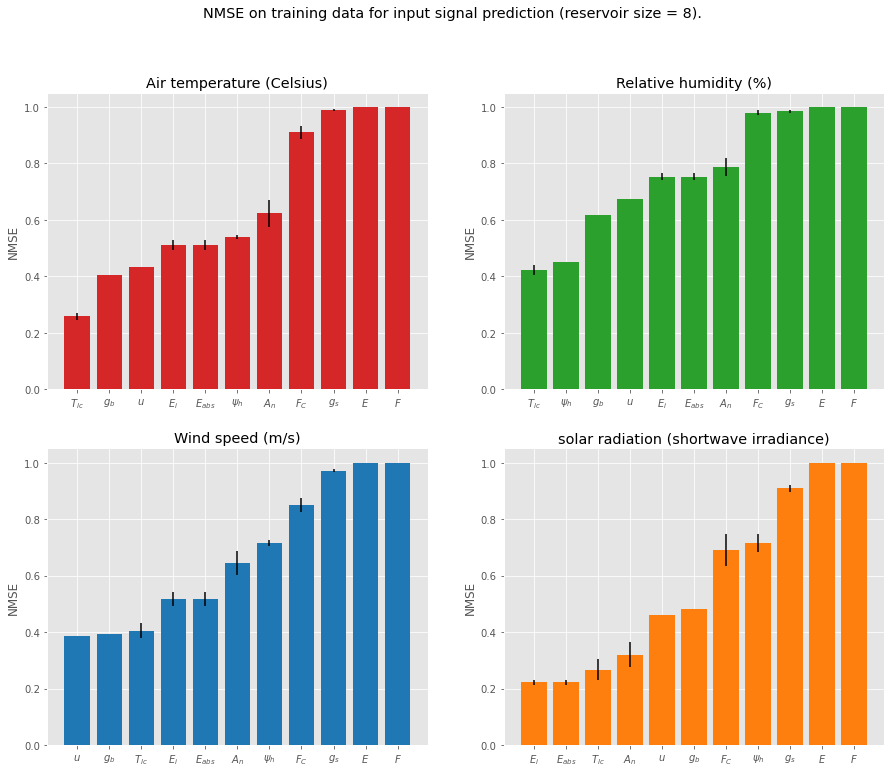

In [14]:
TARGET_COLORS = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
VARIABLE_NAMES = ['$A_n$', '$E_i$', '$u$', '$T_{lc}$', '$F$', '$E_{abs}$', '$g_s$', '$E$', '$g_b$', '$\psi_{h}$', '$F_C$']

BAR_WIDTH = 0.8

X = np.arange(len(STATE_VARIABLES))

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(2, 2, figsize=(15, 12))

  for i, target in enumerate(TARGETS):
    row = i // 2
    col = i % 2

    ranked_errors_idx = np.argsort(errors_mean[i, :])
    ranked_err_mean = errors_mean[i, ranked_errors_idx]
    ranked_err_std = errors_std[i, ranked_errors_idx]
    ax[row, col].bar(X, ranked_err_mean, BAR_WIDTH, yerr=ranked_err_std, color=TARGET_COLORS[i])

    ax[row, col].set_title(f'{INPUT_DESCS[target]}')
    ax[row, col].set_xticks(X)
    ax[row, col].set_xticklabels(np.array(VARIABLE_NAMES)[ranked_errors_idx])
    ax[row, col].set_ylabel('NMSE')

  fig.suptitle(f"NMSE on training data for input signal prediction (reservoir size = {STATE_SIZE}).", size='x-large')
  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_PRC_NSME_input_prediction.png'), dpi=200)
  plt.show()


**Key takeaways:**

- $T_{\mathrm{leaf}}$ is a good reservoir variable for predicting all four inputs, and is also readily observable in vivo.

## Experiment 2: Reconstructing plant-level outputs

### reservoir size 8, homogeneous state variables

**Goal:** Determine the performance of each leaf variable at predicting each of the plant-level outputs

In [15]:
STATE_SIZE = 8
TARGETS = ['An', 'E', 'Rg', 'Tleaf']
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
REGULARIZATION_STRENGTH = 1  # Ridge regression parameter

np.random.seed(42)

In [16]:
# Create the array of the reservoir state history.
states = get_state_data_subset(state_data, STATE_SIZE, N_SAMPLINGS)
targets = plant_output[TARGETS].to_numpy()

print(f'States shape: {states.shape} = (time_step, n_samplings, leaf, state_variable)')
print(f'Target shape: {targets.shape} = (time_step, target_variable)')

States shape: (96, 100, 8, 11) = (time_step, n_samplings, leaf, state_variable)
Target shape: (96, 4) = (time_step, target_variable)


In [17]:
errors_mean = np.zeros((len(TARGETS), len(STATE_VARIABLES)))
errors_std = np.zeros(errors_mean.shape)

for i, target in enumerate(TARGETS):
  for j, var in enumerate(STATE_VARIABLES):
    mean, std = evaluate_reservoir_training_score(targets[:, i], states[:, :, :, j])
    errors_mean[i, j] = mean
    errors_std[i, j] = std

print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (4, 11)  min: 0.2142   max: 1.0000  
 errors_std shape: (4, 11)  min: 0.0000   max: 0.0719  


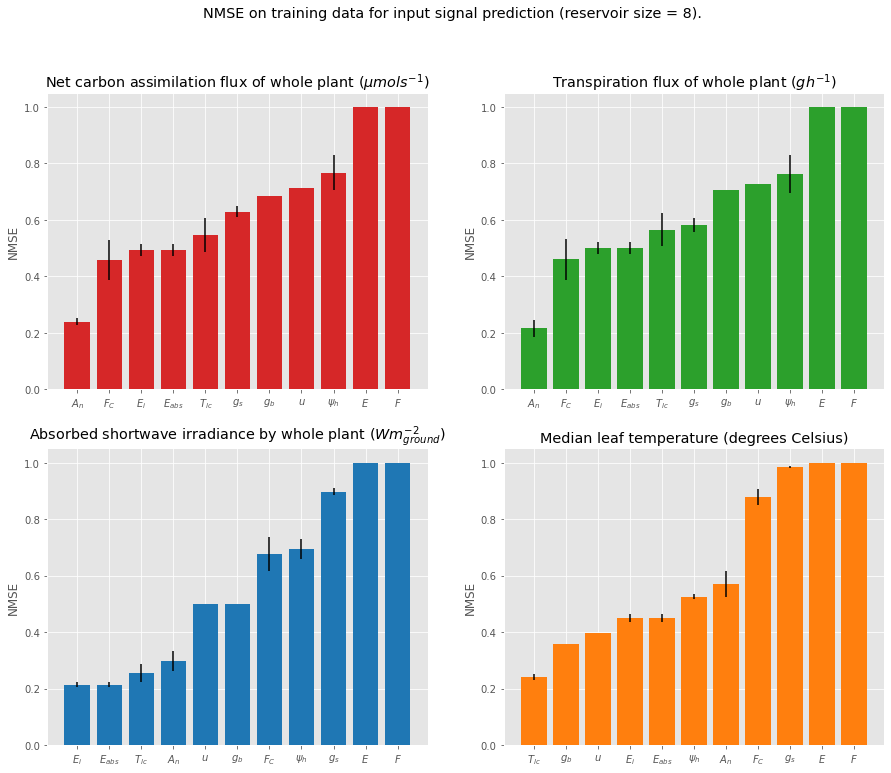

In [18]:
TARGET_COLORS = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
VARIABLE_NAMES = ['$A_n$', '$E_i$', '$u$', '$T_{lc}$', '$F$', '$E_{abs}$', '$g_s$', '$E$', '$g_b$', '$\psi_{h}$', '$F_C$']

BAR_WIDTH = 0.8

X = np.arange(len(STATE_VARIABLES))

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(2, 2, figsize=(15, 12))

  for i, target in enumerate(TARGETS):
    row = i // 2
    col = i % 2

    ranked_errors_idx = np.argsort(errors_mean[i, :])
    ranked_err_mean = errors_mean[i, ranked_errors_idx]
    ranked_err_std = errors_std[i, ranked_errors_idx]
    ax[row, col].bar(X, ranked_err_mean, BAR_WIDTH, yerr=ranked_err_std, color=TARGET_COLORS[i])

    ax[row, col].set_title(f'{OUTPUT_DESCS[target]}')
    ax[row, col].set_xticks(X)
    ax[row, col].set_xticklabels(np.array(VARIABLE_NAMES)[ranked_errors_idx])
    ax[row, col].set_ylabel('NMSE')

  fig.suptitle(f"NMSE on training data for input signal prediction (reservoir size = {STATE_SIZE}).", size='x-large')
  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_PRC_NSME_output_prediction.png'), dpi=200)
  plt.show()

## Experiment 3: Information content per observed leaf

## Variable reservoir size, homogeneous state variables, 

**Goal:** Determine the gained performance per observed leaf in the reservoir state.

#### target: plant-level output


In [19]:
STATE_SIZES = [1, 2, 4, 8, 16, 32, 64]
TARGET = 'An'
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
REGULARIZATION_STRENGTH = 1  # Ridge regression parameter

np.random.seed(42)

In [20]:
errors_mean = np.zeros((len(STATE_SIZES), len(STATE_VARIABLES)))
errors_std = np.zeros(errors_mean.shape)

for i, size in enumerate(STATE_SIZES):
  states = get_state_data_subset(state_data, size, N_SAMPLINGS)
  target = plant_output[TARGET].to_numpy()
  for j, var in enumerate(STATE_VARIABLES):
    mean, std = evaluate_reservoir_training_score(target, states[:, :, :, j])
    errors_mean[i, j] = mean
    errors_std[i, j] = std

print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (7, 11)  min: 0.1218   max: 1.0000  
 errors_std shape: (7, 11)  min: 0.0000   max: 0.1399  


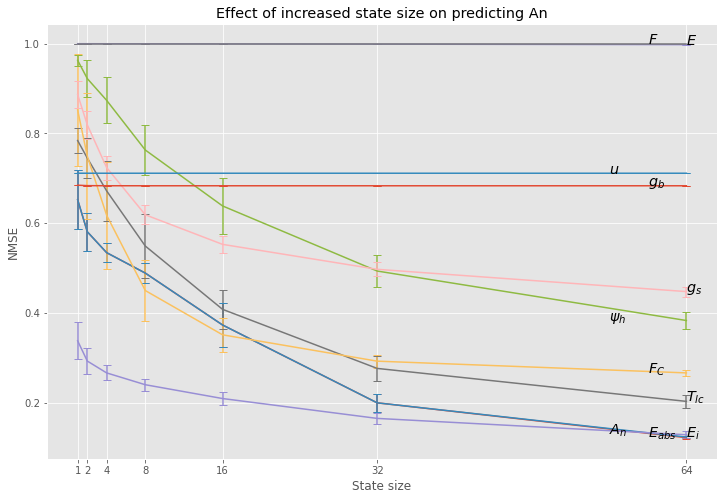

In [21]:
with plt.style.context('ggplot'):

  fig, ax = plt.subplots(figsize=(12, 8))

  sort_key = np.argsort(errors_mean[-1, :])
  errors_mean_sorted = errors_mean[:, sort_key]
  errors_std_sorted = errors_std[:, sort_key]
  names_sorted = np.array(VARIABLE_NAMES)[sort_key]

  for i, var in enumerate(names_sorted):
    ax.errorbar(STATE_SIZES, errors_mean_sorted[:, i], yerr=errors_std_sorted[:, i], capsize=4)
    ax.text(STATE_SIZES[-1] - 4 * (i%3), errors_mean_sorted[-1, i], var, size='x-large')
  
  ax.set_title(f'Effect of increased state size on predicting {TARGET}')
  ax.set_xticks(STATE_SIZES)
  ax.set_ylabel('NMSE')
  ax.set_xlabel('State size')

  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_PRC_NSME_state_size.png'), dpi=200)
  plt.show()

## Experiment 4: Hetereogeneous state variables

## Reservoir size 16, Heterogeneous state variables

**Goal:** How coupled are the different state variables? What is the additional information gained with each variable?

In [22]:
STATE_SIZE = 16
TARGET = 'An'
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
REGULARIZATION_STRENGTH = 1  # Ridge regression parameter

np.random.seed(42)

In [23]:
errors_mean = np.zeros((len(STATE_VARIABLES), len(STATE_VARIABLES)))
errors_std = np.zeros(errors_mean.shape)

for i, var1 in enumerate(STATE_VARIABLES):
  states = get_state_data_subset(state_data, STATE_SIZE, N_SAMPLINGS)
  target = plant_output[TARGET].to_numpy()
  for j, var2 in enumerate(STATE_VARIABLES):
    state = states[:, :, :, (i, j)]
    state = state.reshape((len(env_input), N_SAMPLINGS, -1))  # ridge model requires flattened input shape
    mean, std = evaluate_reservoir_training_score(target, state)
    errors_mean[i, j] = mean
    errors_std[i, j] = std

print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (11, 11) min: 0.1551   max: 1.0000  
 errors_std shape: (11, 11) min: 0.0000   max: 0.0579  


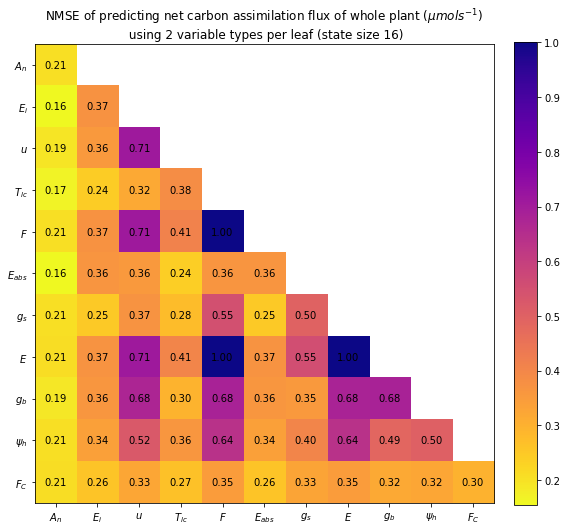

In [24]:
fig, ax = plt.subplots(figsize=(9, 9))

tril_mask = np.tril(np.ones((len(STATE_VARIABLES), len(STATE_VARIABLES)), dtype=bool))
plt_data = np.where(tril_mask, errors_mean, np.nan)

img = ax.imshow(plt_data, cmap='plasma_r')
for (col, row), value in np.ndenumerate(plt_data):
  if not np.isnan(value):
    ax.text(row, col, f'{value:.2f}', ha='center', va='center')

ax.set_xticks(np.arange(len(STATE_VARIABLES)))    
ax.set_xticklabels(VARIABLE_NAMES)
ax.set_yticks(np.arange(len(STATE_VARIABLES)))    
ax.set_yticklabels(VARIABLE_NAMES)

ax.set_title(f'NMSE of predicting {OUTPUT_DESCS[TARGET].lower()}\n using 2 variable types per leaf (state size {STATE_SIZE})')
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_PRC_NSME_hetereogeneous_state.png'), dpi=200)
plt.show()

## Experiment 5: predicting time-delayed inputs

### Reservoir size 16, homogeneous state variables

**Goal:** What is the plant's memory capacity, and is there any latency between input signal and state update?

In [25]:
STATE_SIZE = 16
TARGET = 'Rg'
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
REGULARIZATION_STRENGTH = 1  # Ridge regression parameter
OFFSETS = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Up to 6 hour offsets

np.random.seed(42)

In [26]:
errors_mean = np.zeros((len(OFFSETS), len(STATE_VARIABLES)))
errors_std = np.zeros(errors_mean.shape)

for i, o in enumerate(OFFSETS):
  states = get_state_data_subset(state_data, STATE_SIZE, N_SAMPLINGS)
  states = states[o:, :, :, :]
  target = plant_output[TARGET].to_numpy()[:len(plant_output) - o]
  for j, var2 in enumerate(STATE_VARIABLES):
    state = states[:, :, :, j]
    mean, std = evaluate_reservoir_training_score(target, state)
    errors_mean[i, j] = mean
    errors_std[i, j] = std

print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (9, 11)  min: 0.1913   max: 1.0000  
 errors_std shape: (9, 11)  min: 0.0000   max: 0.0432  


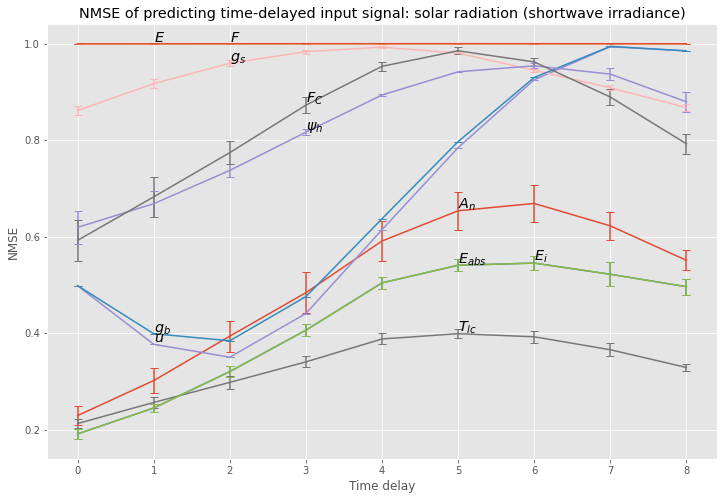

In [30]:
label_loc = [5, 6, 1, 5, 2, 5, 2, 1, 1, 3, 3] # [5, 4.8, 5, 5, 4.8, 5, 1, 5, 4.7, 5, 5]
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(figsize=(12, 8))

  for i, var in enumerate(VARIABLE_NAMES):
    ax.errorbar(OFFSETS, errors_mean[:, i], yerr=errors_std[:, i], capsize=4, label=var)
    ax.text(label_loc[i], errors_mean[int(label_loc[i]), i] + 0.005, var, size='x-large')
  
  # ax.set_xticks(OFFSETS)                            # For some reason this gives exceptions when running the notebook
  # ax.set_xticklabels([f'+{o} h' for o in OFFSETS])  # from another session using iPython magic %run
  ax.set_ylabel('NMSE')
  ax.set_xlabel('Time delay (h)')
  ax.set_title(f'NMSE of predicting time-delayed input signal: {INPUT_DESCS[TARGET]}')
  
  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_PRC_NSME_time_delay.png'), dpi=200)
  plt.show()

In [28]:
A = np.zeros(5)